## PLS1.0

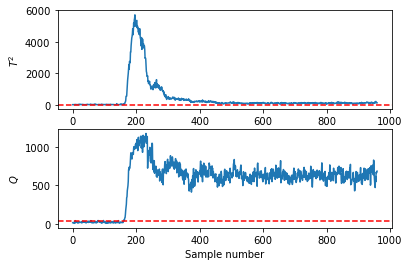

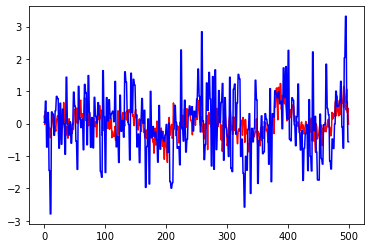

In [179]:
# 导入相关库
import numpy as np
from scipy.io import loadmat
import scipy.stats
import matplotlib.pyplot as plt


def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new

def pls_nipals(X, Y, A, max_iter=2000, epsilon=1e-10):
    olv=A
    rankx=np.linalg.matrix_rank(X)
    if olv>=rankx:
        A=rankx
        
    ssqx=np.sum(X**2)
    ssqy=np.sum(Y**2)
    ssq=np.zeros((A,2))
    ssqdiff=np.zeros((A,2))
    t_old = 0
    iters = 0 
    u = Y[:,0].reshape(Y.shape[0],1)
    while iters < max_iter:
        W = X.T @ u / (np.linalg.norm(X.T @ u))
        W = W/np.linalg.norm(W)
        T = X @ W
        Q = Y.T @ T / (T.T @ T)
        Q=Q/np.linalg.norm(Q)
        u = Y @ Q
        t_diff = T - t_old
        t_old = T
        if np.linalg.norm(t_diff) < epsilon:
            P = X.T @ T / (T.T @ T)
            X = X - T @ (P.T)
            B=u.T@T/(T.T@T)
            Y=Y-B[0,0]*T@Q.T
            break
        else:
            iters += 1
            
    ssq[0,0] = np.sum(X**2)*100/ssqx;
    ssq[0,1] = np.sum(Y**2)*100/ssqy;
    
    for i in range(1,A):
        t_old = 0
        iters = 0
        u = Y[:,0].reshape(Y.shape[0],1)
        while iters < max_iter:
            w = X.T @ u / (np.linalg.norm(X.T @ u))
            w = w/np.linalg.norm(w)
            t = X @ w
            q = Y.T @ t / (t.T @ t)
            q=q/np.linalg.norm(q)
            u = Y @ q
            t_diff = t - t_old
            t_old = t
            if np.linalg.norm(t_diff) < epsilon:
                p = X.T @ t / (t.T @ t)
                p=p/np.linalg.norm(p)
                X = X - t @ (p.T)
                b=u.T@t/(t.T@t)
                Y=Y-b[0,0]*t@q.T
                t_old = t
                T = np.hstack((T,t))               
                W = np.hstack((W,w))
                Q = np.hstack((Q,q))
                P = np.hstack((P,p))
                B = np.hstack((B,b))
                break
            else:
                iters += 1    
        ssq[i,0] = np.sum(X**2)*100/ssqx;
        ssq[i,1] = np.sum(Y**2)*100/ssqy;

    ssqdiff[0,0] = 100 - ssq[0,0];
    ssqdiff[0,1] = 100 - ssq[0,1];
    ssqdiff[1:,:]=ssq[0:-1,:]-ssq[1:,:]
    R = W @ np.linalg.inv((P.T @ W))
    return T,W,Q,P,R,B,ssqdiff,ssq




# path_train = r'D:/program/matlab/PLS/PLS/PLS1.0/data/d00.mat'
# path_test = r'D:/program/matlab/PLS/PLS/PLS1.0/data/d01te.mat'
path_train = r'D:\program\matlab\PLS\PLS\PLS1.0\data\d00.mat'
path_test = r'D:\program\python\故障诊断\PLS\PLS1.0\data\d01te.mat'
data1 = loadmat(path_train)['d00']
X1 = data1[:,:22]
X2 = data1[:,-11:]
X_Train= np.hstack((X1,X2))
Y_Train = data1[:,34:35]

data2 = loadmat(path_test)['d01te']
X11 = data2[:,:22]
X22 = data2[:,-11:]
X_test = np.hstack((X11,X22))
# Y_test  = data2[:,34:36]
Y_test  = data2[:,34:35]

# 数据标准化
##训练数据标准化
X_train,X_mean,X_s = autos(X_Train)
Y_train,Y_mean,Y_s = autos(Y_Train)
##测试数据标准化
X_test = autos_test(X_test,X_mean,X_s)
Y_test = autos_test(Y_test,Y_mean,Y_s)


A = 6  # pls主元数
T, W, Q, P, R, B, ssqdiff, ssq = pls_nipals(X_train, Y_train, A, max_iter=10000, epsilon=1e-10)

## pls建模
alpha=0.95;# 显著性水平
X_hat = X_train-X_train@R@P.T
n = X_train.shape[0]
T2_lim = A*(n** 2-1)/(n*(n-A)) * scipy.stats.f.ppf(alpha, A, n-A)  # T2控制限 

# 计算控制限
Qx_normal=[]
for i in range(X_hat.shape[0]):
    Qx_normal.append(X_hat[i,:].T @ X_hat[i,:])
S1=np.var(Qx_normal); 
mio1=np.mean(Qx_normal);
V1=2*mio1**2/S1; 
Q_lim=S1/(2*mio1)*scipy.stats.chi2.ppf(alpha,V1);

# 计算测试数据的监控结果
T_value = []
Q_value = []
for i in range(X_test.shape[0]):
    t = R.T @ X_test[i,:]
    xr_old = X_test[i,:].T-P@R.T@X_test[i,:].T
    T_value.append(t.T @ np.linalg.inv((T.T @ T) / (X_train.shape[0] - 1)) @ t)
    Q_value.append(xr_old.T@xr_old)

# 对测试数据的监控结果可视化
plt.figure()
plt.subplot(2,1,1)
plt.plot(T_value)
plt.xlabel('Sample number')
plt.ylabel('$T^2$')
plt.axhline(y=T2_lim,ls="--",color="r")
plt.subplot(2,1,2)
plt.plot(Q_value)
plt.xlabel('Sample number')
plt.ylabel('$Q$')
plt.axhline(y=Q_lim,ls="--",color="r")
plt.show()

# pls预测结果可视化
T_pred = X_train @ R;
Y_pred = T_pred @ np.diag(B[0])@ Q.T;

plt.figure()
plt.plot(Y_pred,color="r")
plt.plot(Y_train,color="b")
plt.show()


## PLS2.0

- 1. 修改pls_nipals
- 2.加入变量重要性

### pls_nipals 升级

In [2]:
def pls_nipals(X, Y, A, max_iter=2000, epsilon=1e-10):
    olv=A
    rankx=np.linalg.matrix_rank(X)
    if olv>=rankx:
        A=rankx
        
    ssqx=np.sum(X**2)
    ssqy=np.sum(Y**2)
    ssq=np.zeros((A,2))
    ssqdiff=np.zeros((A,2))
    t_old = 0
    iters = 0 
    u = Y[:,0].reshape(Y.shape[0],1)
    while iters < max_iter:
        W = X.T @ u / (np.linalg.norm(X.T @ u))
        W = W/np.linalg.norm(W)
        T = X @ W
        Q = Y.T @ T / (T.T @ T)
        Q=Q/np.linalg.norm(Q)
        u = Y @ Q
        t_diff = T - t_old
        t_old = T
        if np.linalg.norm(t_diff) < epsilon:
            P = X.T @ T / (T.T @ T)
            X = X - T @ (P.T)
            B=u.T@T/(T.T@T)
            Y=Y-B[0,0]*T@Q.T
            break
        else:
            iters += 1
    R = W
            
    ssq[0,0] = np.sum(X**2)*100/ssqx;
    ssq[0,1] = np.sum(Y**2)*100/ssqy;
    
    for i in range(1,A):
        t_old = 0
        iters = 0
        u = Y[:,0].reshape(Y.shape[0],1)
        while iters < max_iter:
            w = X.T @ u / (np.linalg.norm(X.T @ u))
            w = w/np.linalg.norm(w)
            t = X @ w
            q = Y.T @ t / (t.T @ t)
            q=q/np.linalg.norm(q)
            u = Y @ q
            t_diff = t - t_old
            t_old = t
            if np.linalg.norm(t_diff) < epsilon:
                p = X.T @ t / (t.T @ t)
                X = X - t @ (p.T)
#                 p=p/np.linalg.norm(p)
                b=u.T@t/(t.T@t)
                Y=Y-b[0,0]*t@q.T
#                 t_old = t
                r = np.identity(X.shape[1])
                for i in range(W.shape[1]):
#                     print(W[:,i:i+1]@(P[:,i:i+1].T), X.shape[1])
                    r =  r @ (np.identity(X.shape[1])- W[:,i:i+1]@(P[:,i:i+1].T))
                r = r @ w
                T = np.hstack((T,t))               
                W = np.hstack((W,w))
                Q = np.hstack((Q,q))
                P = np.hstack((P,p))
                B = np.hstack((B,b))
                R = np.hstack((R,r))
                break         
            else:
                iters += 1    
        ssq[i,0] = np.sum(X**2)*100/ssqx;
        ssq[i,1] = np.sum(Y**2)*100/ssqy;

    ssqdiff[0,0] = 100 - ssq[0,0];
    ssqdiff[0,1] = 100 - ssq[0,1];
    ssqdiff[1:,:]=ssq[0:-1,:]-ssq[1:,:]
#     R = W @ np.linalg.inv((P.T @ W))
    return T,W,Q,P,R,B,ssqdiff,ssq


- 检查W是否为单位，但为什么有正交互补

In [ ]:
W.T@W

### 计算变量相关性

In [33]:
def pls_vip(X, T, W, Q):
    """
    计算模型中各预测变量的VIP值
    :param X: 数据集X
    :param A: PLS成分的总数
    :param R: A个PLS成分中，每个成分a都对应一套系数wa将X转换为成分得分，系数矩阵写作R，大小为p×A
    :param T: 得分矩阵记做T，大小为n×A，ta代表n个样本的第a个成分的得分列表

    :return: VIPs = np.zeros(p)
    """
    _, p =  X.shape
    n, h = T.shape
#     s=np.diag(T.T@T@np.diag((B**2)[0]))/(n-1)
    s=np.diag(T.T@T@Q.T@(Q))

    VIPs = np.zeros(p)
    for i in range(p):
        weight = np.zeros(h)
        for j in range(h):
            weight[j]=(W[i, j]**2)
        q = s.T@np.array(weight)
#         VIPs.append()
        VIPs[i] = np.sqrt(p*q/np.sum(s))
    return VIPs
VIPs = pls_vip(X_train, T, W, Q)
VIPs

array([0.56188714, 0.64316165, 0.57396827, 1.02395262, 0.24433264,
       1.25178584, 1.76791458, 0.73520091, 1.05794362, 1.06899274,
       0.96158432, 0.40296589, 1.73445594, 0.63936035, 0.45498036,
       1.65145966, 0.26359726, 1.72882434, 1.17670049, 1.42800241,
       0.75127331, 0.56216742, 0.73703196, 1.11526787, 0.56200746,
       0.77939096, 1.34613001, 1.19899217, 0.4029334 , 0.45492313,
       1.19150393, 0.82825901, 0.31932314])

- VIPs变量重要性可视化

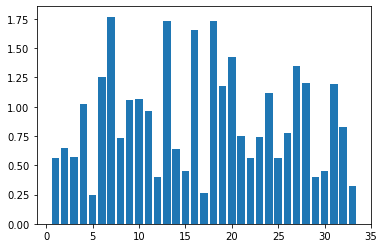

In [34]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(np.arange(1, len(VIPs)+1, 1),np.abs(VIPs))
plt.show()

- 验证vip平方和是否等于变量个数

In [35]:
np.sum(VIPs**2)

33.00000000000001

- 检查P@R是否是单位矩阵

In [224]:
P.T@R

array([[ 1.00000000e+00, -7.94700631e-17, -1.70176377e-17,
         4.59316947e-18,  5.18560672e-17,  4.94803876e-17],
       [ 2.17834684e-17,  1.00000000e+00, -1.34716764e-16,
        -6.57248358e-17,  2.40826333e-17,  4.68462387e-17],
       [-4.61103728e-17, -2.13990540e-16,  1.00000000e+00,
         4.70127278e-17, -4.77798920e-17, -3.09392408e-17],
       [ 7.37998936e-17, -3.41162485e-17, -8.89480308e-17,
         1.00000000e+00, -1.41473570e-16, -3.29331779e-16],
       [ 1.10143378e-16, -6.73865146e-18,  9.80929711e-17,
         4.52192464e-17,  1.00000000e+00,  2.79958343e-17],
       [ 1.46511946e-16, -1.12709589e-16, -8.15961113e-17,
        -1.74849231e-16,  3.58349885e-16,  1.00000000e+00]])

- 检查是否通过R矩阵

In [229]:
T_pred, T, np.mean(T-T_pred)

array([[ 0.50266068,  0.50730401,  0.35152607, -0.11118697, -0.30757172,
         0.71920356],
       [ 0.24736906,  0.05602576, -1.34890753, -0.47954368,  0.77123063,
         0.1050884 ],
       [ 1.00720023,  0.98660588, -0.87929608,  0.56775055,  1.06527503,
         0.16152033],
       ...,
       [ 3.89271799, -0.0146123 , -0.50010955,  0.06776647, -0.92999654,
        -0.44678573],
       [ 2.07444199,  0.01170919, -1.78532802,  1.84113655,  2.78577527,
        -0.64482818],
       [ 1.32802233, -1.1111933 , -2.42945338,  1.77441901,  2.71790479,
        -1.81228024]])

- 检测解释方差和

In [251]:
np.sum(np.sum((T_pred @ np.diag(B[0]))**2, axis=0)/499)

0.12534834972224967

In [48]:
np.sum(np.diag(T.T@T)/499.*(B**2)), np.diag(T.T@T)/499.*(B**2)

0.12357928608225317

In [53]:
T_pred = X_train @ R
np.diag(T_pred.T@T_pred)/500

array([5.00227104, 1.4589619 , 1.95912223, 1.68869721, 2.13809572,
       1.92391051])

### pls计算vip相关性方式2： 使用PLSRegression

In [315]:
from sklearn.cross_decomposition import PLSRegression
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
pls2 = PLSRegression(n_components=2)
# pls2.fit(X_train, Y_train)
pls2.fit(X, Y)


def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    print(s)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips
VIPs2 = _calculate_vips(pls2)
print('VIP平方和为', np.sum(VIPs2**2))
VIPs2

[[5.95408577]
 [0.00870148]]
VIP平方和为 2.9999999999999996


array([0.90486935, 1.0686175 , 1.01944499])

### 故障诊断贡献图

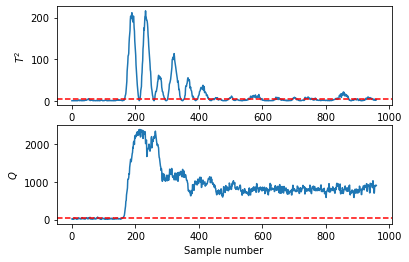

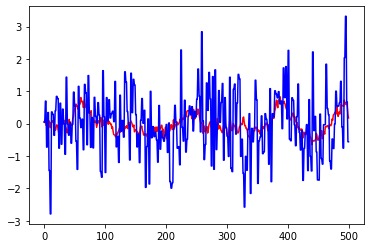

In [30]:
# 导入相关库
import numpy as np
from scipy.io import loadmat
import scipy.stats
import matplotlib.pyplot as plt


def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new


path_train = r'D:\program\matlab\PLS\PLS\PLS1.0\data\d00.mat'
path_test = r'D:\program\python\故障诊断\PLS\PLS1.0\data\d01te.mat'
data1 = loadmat(path_train)['d00']
X1 = data1[:,:22]
X2 = data1[:,-11:]
X_Train= np.hstack((X1,X2))
Y_Train = data1[:,34:35]

data2 = loadmat(path_test)['d01te']
X11 = data2[:,:22]
X22 = data2[:,-11:]
X_test = np.hstack((X11,X22))
# Y_test  = data2[:,34:36]
Y_test  = data2[:,34:35]

# 数据标准化
##训练数据标准化
X_train,X_mean,X_s = autos(X_Train)
Y_train,Y_mean,Y_s = autos(Y_Train)
##测试数据标准化
X_test = autos_test(X_test,X_mean,X_s)
Y_test = autos_test(Y_test,Y_mean,Y_s)


A = 1  # pls主元数
T, W, Q, P, R, B, ssqdiff, ssq = pls_nipals(X_train, Y_train, A, max_iter=5000, epsilon=1e-10)

## pls建模
alpha=0.95;# 显著性水平
X_hat = X_train-X_train@R@P.T
n = X_train.shape[0]
T2_lim = A*(n** 2-1)/(n*(n-A)) * scipy.stats.f.ppf(alpha, A, n-A)  # T2控制限 

# 计算控制限
Qx_normal=[]
for i in range(X_hat.shape[0]):
    Qx_normal.append(X_hat[i,:].T @ X_hat[i,:])
S1=np.var(Qx_normal); 
mio1=np.mean(Qx_normal);
V1=2*mio1**2/S1; 
Q_lim=S1/(2*mio1)*scipy.stats.chi2.ppf(alpha,V1);

# 计算测试数据的监控结果
T_value = []
Q_value = []
for i in range(X_test.shape[0]):
    t = R.T @ X_test[i,:]
    xr_old = X_test[i,:].T-P@R.T@X_test[i,:].T
    T_value.append(t.T @ np.linalg.inv((T.T @ T) / (X_train.shape[0] - 1)) @ t)
    Q_value.append(xr_old.T@xr_old)

# 对测试数据的监控结果可视化
plt.figure()
plt.subplot(2,1,1)
plt.plot(T_value)
plt.xlabel('Sample number')
plt.ylabel('$T^2$')
plt.axhline(y=T2_lim,ls="--",color="r")
plt.subplot(2,1,2)
plt.plot(Q_value)
plt.xlabel('Sample number')
plt.ylabel('$Q$')
plt.axhline(y=Q_lim,ls="--",color="r")
plt.show()

# pls预测结果可视化
T_pred = X_train @ R;
Y_pred = T_pred @ np.diag(B[0])@ Q.T;

plt.figure()
plt.plot(Y_pred,color="r")
plt.plot(Y_train,color="b")
plt.show()



### 贡献图

In [33]:
from scipy.linalg import fractional_matrix_power
lambda_ = (fractional_matrix_power((T.T@T/T.shape[0]), -1))
lambda_ = np.diag(np.diag(lambda_))
gama = fractional_matrix_power(R@lambda_@R.T, 1/2)
# gama = np.real(gama)
gama

array([[ 1.95081057e-05+0.00000000e+00j,  8.73102454e-06+1.34635941e-09j,
        -3.26710101e-04-1.05392864e-11j, ...,
         4.34687750e-04-1.29032363e-11j, -1.05104137e-04+4.02587951e-11j,
         7.80826240e-06+1.46830192e-11j],
       [ 8.73188466e-06+0.00000000e+00j,  3.90896613e-06-1.21074873e-10j,
        -1.46236390e-04+8.85675724e-12j, ...,
         1.94567467e-04-3.32388080e-12j, -4.70448935e-05-1.81178328e-13j,
         3.49499523e-06+3.28626632e-13j],
       [-3.26710099e-04+0.00000000e+00j, -1.46257682e-04-9.03729277e-09j,
         5.47154602e-03+6.41533817e-10j, ...,
        -7.27989059e-03+3.24243570e-10j,  1.76022020e-03-2.20299822e-10j,
        -1.30767894e-04+1.72397501e-11j],
       ...,
       [ 4.34687723e-04+0.00000000e+00j,  1.94605050e-04-1.40275413e-08j,
        -7.27989052e-03+3.03385403e-10j, ...,
         9.68589216e-03-2.07820109e-10j, -2.34197248e-03-1.74183940e-10j,
         1.73986669e-04+1.67750388e-11j],
       [-1.05104092e-04+0.00000000e+00j, -4.

In [36]:
R

array([[ 0.0066054 ],
       [ 0.0029566 ],
       [-0.11062335],
       [-0.0302707 ],
       [-0.01025069],
       [-0.12985395],
       [-0.424478  ],
       [-0.1151989 ],
       [-0.03310534],
       [ 0.20550283],
       [ 0.20409901],
       [ 0.04058959],
       [-0.41773996],
       [-0.05215891],
       [ 0.02539281],
       [-0.39484716],
       [-0.00762413],
       [ 0.22636271],
       [ 0.12286286],
       [-0.24722298],
       [ 0.10195612],
       [ 0.0447151 ],
       [ 0.00997424],
       [-0.19888569],
       [ 0.00496883],
       [ 0.07892725],
       [-0.29055623],
       [ 0.24596369],
       [ 0.04059894],
       [ 0.02538238],
       [ 0.14718435],
       [-0.03558802],
       [ 0.00264386]])

In [32]:
lambda_

array([[0.1999092]])

In [27]:
T.T@T/T.shape[0]

array([[ 5.00227104e+00, -3.12638804e-16, -7.10542736e-17,
        -8.24229573e-16, -5.75539616e-16, -7.78044296e-16],
       [-3.12638804e-16,  1.16484483e+00, -1.91069383e-16,
        -2.06057393e-16, -3.05533376e-16, -2.62900812e-16],
       [-7.10542736e-17, -1.91069383e-16,  1.39277230e+00,
        -7.46069873e-17,  3.55271368e-17, -7.10542736e-18],
       [-8.24229573e-16, -2.06057393e-16, -7.46069873e-17,
         7.66428961e-01, -7.10542736e-17, -1.22568622e-16],
       [-5.75539616e-16, -3.05533376e-16,  3.55271368e-17,
        -7.10542736e-17,  9.89122658e-01,  1.61648472e-16],
       [-7.78044296e-16, -2.62900812e-16, -7.10542736e-18,
        -1.22568622e-16,  1.61648472e-16,  6.33016007e-01]])

In [28]:
cont = gama @ X_test[200,:].T

In [29]:
np.argmax(np.abs(cont), axis=0)

17

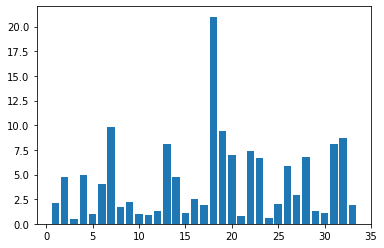

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(np.arange(1, len(cont)+1, 1),np.abs(cont))
plt.show()

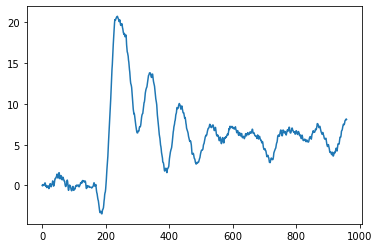

In [30]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X_test[:, 17])
plt.show()

In [356]:
np.sum((gama @ X_test[200,:].T)**2), T_value[200]

1198.9119994486728

### 交叉验证选取pls主元数量

In [57]:
def pls_cv(X, Y, A: int, kfold: int):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    from numpy import mean
    kfold = KFold(n_splits = kfold, shuffle = True, random_state = 2022)
    scores = []
    for pc_num in range(A):
        cv_scores = []
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(X, Y)):
            X_train, X_test = X[trn_ind], X[val_ind]
            Y_train, Y_test = Y[trn_ind], Y[val_ind]
            T, W, Q, P, R, B, ssqdiff, ssq = pls_nipals(X_train, Y_train, pc_num+1, max_iter=5000, epsilon=1e-10)
            T_test_pred = X_test @ R;
            Y_test_pred = T_test_pred @ np.diag(B[0])@ Q.T;
            cv_score=mean_squared_error(Y_test, Y_test_pred)
#             T_train_pred = X_train @ R;
#             Y_train_pred = T_train_pred @ np.diag(B[0])@ Q.T;
#             cv_score=mean_squared_error(Y_train, Y_train_pred)
            cv_scores.append(cv_score)
        scores.append(mean(cv_scores))
    best_A = np.argmin(scores)
#     print(scores)
    return best_A
        
        
pls_cv(X_train, Y_train, A=5, kfold=2)

[0.9348895757037459, 1.0004279211673643, 1.0066109946832578, 1.021187870996818, 1.0343200887481485]


0

### 封装成类

In [3]:
# 导入相关库
import numpy as np
from scipy.io import loadmat
import scipy.stats
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new

def pls_nipals(X, Y, A, max_iter=2000, epsilon=1e-10):
        olv = A
        rankx = np.linalg.matrix_rank(X)
        if olv >= rankx:
            A = rankx

        ssqx = np.sum(X**2)
        ssqy = np.sum(Y**2)
        ssq = np.zeros((A,2))
        ssqdiff = np.zeros((A,2))
        t_old = 0
        iters = 0
        u = Y[:, 0].reshape(Y.shape[0], 1)
        while iters < max_iter:
            W = X.T @ u / (np.linalg.norm(X.T @ u))
            W = W/np.linalg.norm(W)
            T = X @ W
            Q = Y.T @ T / (T.T @ T)
            Q=Q/np.linalg.norm(Q)
            u = Y @ Q
            t_diff = T - t_old
            t_old = T
            if np.linalg.norm(t_diff) < epsilon:
                P = X.T @ T / (T.T @ T)
                X = X - T @ (P.T)
                B = u.T@T/(T.T@T)
                Y = Y-B[0,0]*T@Q.T
                break
            else:
                iters += 1
        R = W

        ssq[0,0] = np.sum(X**2)*100/ssqx;
        ssq[0,1] = np.sum(Y**2)*100/ssqy;

        for i in range(1,A):
            t_old = 0
            iters = 0
            u = Y[:,0].reshape(Y.shape[0],1)
            while iters < max_iter:
                w = X.T @ u / (np.linalg.norm(X.T @ u))
                w = w/np.linalg.norm(w)
                t = X @ w
                q = Y.T @ t / (t.T @ t)
                q = q/np.linalg.norm(q)
                u = Y @ q
                t_diff = t - t_old
                t_old = t
                if np.linalg.norm(t_diff) < epsilon:
                    p = X.T @ t / (t.T @ t)
                    X = X - t @ (p.T)
                    # p=p/np.linalg.norm(p)
                    b = u.T@t/(t.T@t)
                    Y = Y-b[0,0]*t@q.T
                    # t_old = t
                    # r = np.identity(X.shape[1])
                    # for i in range(W.shape[1]):
                    #     # print(W[:,i:i+1]@(P[:,i:i+1].T), X.shape[1])
                    #     r = r @ (np.identity(X.shape[1])- W[:,i:i+1]@(P[:,i:i+1].T))
                    # r = r @ w
                    T = np.hstack((T,t))
                    W = np.hstack((W,w))
                    Q = np.hstack((Q,q))
                    P = np.hstack((P,p))
                    B = np.hstack((B,b))
                    # R = np.hstack((R,r))
                    break
                else:
                    iters += 1
            ssq[i,0] = np.sum(X**2)*100/ssqx;
            ssq[i,1] = np.sum(Y**2)*100/ssqy;

        ssqdiff[0,0] = 100 - ssq[0,0];
        ssqdiff[0,1] = 100 - ssq[0,1];
        ssqdiff[1:,:] = ssq[0:-1,:]-ssq[1:,:]
        R = W @ np.linalg.inv((P.T @ W))
        return T, W, Q, P, R, B, ssqdiff, ssq

class PLSFaultDiagnosis:
    """
    PLS for FaultDiagnosis
    """
    def __init__(self, A=None, kfold=5, max_iter=5000, epsilon = 1e-10, random_state=2022):
        self.A = None
        self.max_iter = max_iter
        self.epsilon = 1e-10
        self.kfold = kfold
        self.random_state = random_state
        self.model = None
        self.VIPs = None
        self.gama = None



    def fit(self, X, y):
        if not self.A:
            self.A = self.cv(X, y, self.kfold) + 1
        print(self.A)
        T,W,Q,P,R,B,ssqdiff,ssq = pls_nipals(X, y,self.A,self.max_iter,self.epsilon)
        self.model = {'T': T, 'W': W, 'Q': Q, 'P': P, 'R': P, 'B':B}
        self.vip(X)  # 计算得到VIPs属性
        lambda_ = (fractional_matrix_power((T.T@T/T.shape[0]), -1))
        lambda_ = np.diag(np.diag(lambda_))
        self.gama = np.real(fractional_matrix_power(R@lambda_@R.T, 1/2))

    def predict(self, X_test):
        T_test_pred = X_test @ self.model['R'];
        Y_test_pred = T_test_pred @ np.diag(self.model['B'][0])@ self.model['Q'].T;
        return Y_test_pred

    def vip(self, X):
        _, p = X.shape
        T = self.model['T']
        Q = self.model['Q']
        W = self.model['W']
        n, h = T.shape
        s=np.diag(T.T@T@Q.T@(Q))
        VIPs = np.zeros(p)
        for i in range(p):
            weight = np.zeros(h)
            for j in range(h):
                weight[j]=(W[i, j]**2)
            q = s.T@np.array(weight)
            VIPs[i] = np.sqrt(p*q/np.sum(s))
        self.VIPs = VIPs

    def contribution(self, X_test):
        cont = self.gama @ X_test.T
        return cont

    def cv(self, X, Y, kfold):
        from sklearn.model_selection import KFold
        from sklearn.metrics import mean_squared_error
        from numpy import mean
        kfold = KFold(n_splits = kfold, shuffle = True, random_state = 2022)
        scores = []
        for pc_num in range(X.shape[1]//2+1):
            cv_scores = []
            for fold, (trn_ind, val_ind) in enumerate(kfold.split(X, Y)):
                X_train, X_test = X[trn_ind], X[val_ind]
                Y_train, Y_test = Y[trn_ind], Y[val_ind]
                T, W, Q, P, R, B, ssqdiff, ssq = pls_nipals(X_train, Y_train, pc_num+1, self.max_iter, self.epsilon)
                T_test_pred = X_test @ R;
                Y_test_pred = T_test_pred @ np.diag(B[0])@ Q.T;
                cv_score=mean_squared_error(Y_test, Y_test_pred)
                cv_scores.append(cv_score)
            scores.append(mean(cv_scores))
        best_A = np.argmin(scores)
        return best_A
    

## 读取数据
path_train = r'D:\program\matlab\PLS\PLS\PLS1.0\data\d00.mat'
path_test = r'D:\program\python\故障诊断\PLS\PLS1.0\data\d01te.mat'
data1 = loadmat(path_train)['d00']
X1 = data1[:,:22]
X2 = data1[:,-11:]
X_Train= np.hstack((X1,X2))
Y_Train = data1[:,34:35]

data2 = loadmat(path_test)['d01te']
X11 = data2[:,:22]
X22 = data2[:,-11:]
X_test = np.hstack((X11,X22))
# Y_test  = data2[:,34:36]
Y_test  = data2[:,34:35]

# 数据标准化
##训练数据标准化
X_train,X_mean,X_s = autos(X_Train)
Y_train,Y_mean,Y_s = autos(Y_Train)
##测试数据标准化
X_test = autos_test(X_test,X_mean,X_s)
Y_test = autos_test(Y_test,Y_mean,Y_s)

## 新建类
pls = PLSFaultDiagnosis()

## 拟合
pls.fit(X_train, Y_train)

# 预测
Y_test_predict = pls.predict(X_test)

# 预测杰结果可视化
plt.figure()
plt.plot(Y_test_predict,color="r")
plt.plot(Y_test,color="b")
plt.show()

# 贡献图
# cont = pls.contribution(X_test)
cont = pls.contribution(X_test[200,:]).ravel()
# np.argsort(-cont)[:3]

# 贡献图可视化
import matplotlib.pyplot as plt
plt.figure()
plt.bar(np.arange(1, len(cont)+1, 1),np.abs(cont))
plt.show()

1


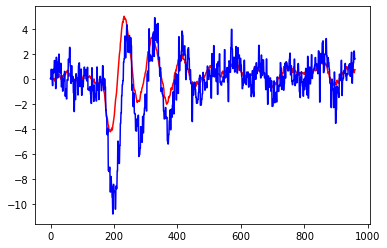

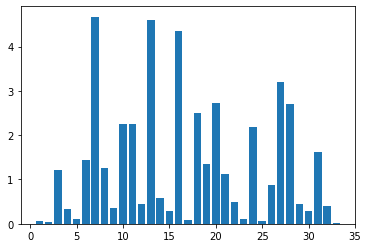

In [18]:
pls.gama

array([[ 1.95081057e-05,  8.73102454e-06, -3.26710101e-04, ...,
         4.34687750e-04, -1.05104137e-04,  7.80826240e-06],
       [ 8.73188466e-06,  3.90896613e-06, -1.46236390e-04, ...,
         1.94567467e-04, -4.70448935e-05,  3.49499523e-06],
       [-3.26710099e-04, -1.46257682e-04,  5.47154602e-03, ...,
        -7.27989059e-03,  1.76022020e-03, -1.30767894e-04],
       ...,
       [ 4.34687723e-04,  1.94605050e-04, -7.27989052e-03, ...,
         9.68589216e-03, -2.34197248e-03,  1.73986669e-04],
       [-1.05104092e-04, -4.70460601e-05,  1.76022059e-03, ...,
        -2.34197323e-03,  5.66270935e-04, -4.20686099e-05],
       [ 7.80824983e-06,  3.49535851e-06, -1.30767906e-04, ...,
         1.73986658e-04, -4.20685977e-05,  3.12531817e-06]])

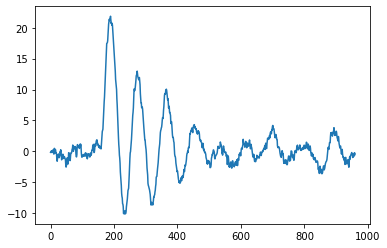

In [41]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X_test[:, 6])
plt.show()

In [16]:
np.argmax(np.abs(cont), axis=0)

6

In [7]:
len(cont)
np.abs(cont)

array([[0.00047179],
       [0.00021118],
       [0.00790134],
       [0.0021621 ],
       [0.00073216],
       [0.00927489],
       [0.03031859],
       [0.00822815],
       [0.00236457],
       [0.01467816],
       [0.01457789],
       [0.00289914],
       [0.02983731],
       [0.00372548],
       [0.0018137 ],
       [0.02820219],
       [0.00054456],
       [0.01616809],
       [0.00877555],
       [0.01765804],
       [0.00728227],
       [0.0031938 ],
       [0.00071242],
       [0.01420553],
       [0.0003549 ],
       [0.00563743],
       [0.02075315],
       [0.0175681 ],
       [0.0028998 ],
       [0.00181295],
       [0.01051273],
       [0.0025419 ],
       [0.00018884]])

- 保存模型

In [94]:
import joblib
joblib.dump(pls, 'PLSFaultDiagnosis_model.pkl')  # joblib.dump(model, f"/root/app/model/LR_predict_{warning_tag}_{warning_time}.pkl")
del pls
pls = joblib.load('PLSFaultDiagnosis_model.pkl')  # joblib.dump(model, f"/root/app/model/LR_predict_{warning_tag}_{warning_time}.pkl")


['PLSFaultDiagnosis_model.pkl']

### 修改bug

- 各种小的bug
- 将标准化与训练结合在一起

In [ ]:
# 导入相关库
import numpy as np
from scipy.io import loadmat
import scipy.stats
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

def autos(X):
    m, n = X.shape
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma


def autos_test(data,m_train,v_train):
    m, n = data.shape
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new


def dis_autos(data_new,m_train,v_train):
    m, n = data_new.shape
    data = np.zeros(data_new.shape)
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data[:, i] = data_new[:, i] * v_train[i] + a
    return data

def pls_nipals(X, Y, A, max_iter=2000, epsilon=1e-10):
        olv = A
        rankx = np.linalg.matrix_rank(X)
        if olv >= rankx:
            A = rankx
        ssqx = np.sum(X**2)
        ssqy = np.sum(Y**2)
        ssq = np.zeros((A,2))
        ssqdiff = np.zeros((A,2))
        t_old = 0
        iters = 0
        u = Y[:, 0].reshape(Y.shape[0], 1)
        while iters < max_iter:
            W = X.T @ u / (np.linalg.norm(X.T @ u))
            W = W/np.linalg.norm(W)
            T = X @ W
            Q = Y.T @ T / (T.T @ T)
            Q=Q/np.linalg.norm(Q)
            u = Y @ Q
            t_diff = T - t_old
            t_old = T
            if np.linalg.norm(t_diff) < epsilon:
                P = X.T @ T / (T.T @ T)
                X = X - T @ (P.T)
                B = u.T@T/(T.T@T)
                Y = Y-B[0,0]*T@Q.T
                break
            else:
                iters += 1
        # R = W

        ssq[0,0] = np.sum(X**2)*100/ssqx;
        ssq[0,1] = np.sum(Y**2)*100/ssqy;

        for i in range(1,A):
            t_old = 0
            iters = 0
            u = Y[:,0].reshape(Y.shape[0],1)
            while iters < max_iter:
                w = X.T @ u / (np.linalg.norm(X.T @ u))
                w = w/np.linalg.norm(w)
                t = X @ w
                q = Y.T @ t / (t.T @ t)
                q = q/np.linalg.norm(q)
                u = Y @ q
                t_diff = t - t_old
                t_old = t
                if np.linalg.norm(t_diff) < epsilon:
                    p = X.T @ t / (t.T @ t)
                    X = X - t @ (p.T)
                    # p=p/np.linalg.norm(p)
                    b = u.T@t/(t.T@t)
                    Y = Y-b[0,0]*t@q.T
                    # t_old = t
                    # r = np.identity(X.shape[1])
                    # for i in range(W.shape[1]):
                    #     # print(W[:,i:i+1]@(P[:,i:i+1].T), X.shape[1])
                    #     r = r @ (np.identity(X.shape[1])- W[:,i:i+1]@(P[:,i:i+1].T))
                    # r = r @ w
                    T = np.hstack((T,t))
                    W = np.hstack((W,w))
                    Q = np.hstack((Q,q))
                    P = np.hstack((P,p))
                    B = np.hstack((B,b))
                    # R = np.hstack((R,r))
                    break
                else:
                    iters += 1
            ssq[i,0] = np.sum(X**2)*100/ssqx;
            ssq[i,1] = np.sum(Y**2)*100/ssqy;

        ssqdiff[0,0] = 100 - ssq[0,0];
        ssqdiff[0,1] = 100 - ssq[0,1];
        ssqdiff[1:,:] = ssq[0:-1,:]-ssq[1:,:]
        R = W @ np.linalg.inv((P.T @ W))
        return T, W, Q, P, R, B, ssqdiff, ssq

class PLSFaultDiagnosis:
    """
    PLS for FaultDiagnosis
    """
    def __init__(self, A=None, kfold=5, max_iter=10000, epsilon=1e-10, random_state=2022):
        self.A = None
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.kfold = kfold
        self.random_state = random_state
        self.model = None
        self.VIPs = None
        self.gama = None
        self.avg_x = None
        self.avg_y = None
        self.std_x = None
        self.std_y = None

    def fit(self, X, y):
        # 数据标准化
        X, self.avg_x, self.std_x = autos(X)
        y, self.avg_y, self.std_y = autos(y)
        if not self.A:
            self.A = self.cv(X, y, self.kfold)
        print(self.A)
        T,W,Q,P,R,B,ssqdiff,ssq = pls_nipals(X, y,self.A,self.max_iter,self.epsilon)
        self.model = {'T': T, 'W': W, 'Q': Q, 'P': P, 'R': P, 'B':B}
        self.vip(X)  # 计算得到VIPs属性
        lambda_ = (fractional_matrix_power((T.T@T/T.shape[0]), -1))
        lambda_ = np.diag(np.diag(lambda_))
        self.gama = np.real(fractional_matrix_power(R@lambda_@R.T, 1/2))

    def predict(self, X_test):
        X_test_ = X_test.copy()
        X_test_ = autos_test(X_test_, self.avg_x, self.std_x)
        T_test_pred = X_test_ @ self.model['R'];
        Y_test_pred = T_test_pred @ np.diag(self.model['B'][0])@ self.model['Q'].T;
        Y_test_pred = dis_autos(Y_test_pred, self.avg_y, self.std_y)
        return Y_test_pred

    def vip(self, X):
        _, p = X.shape
        T = self.model['T']
        Q = self.model['Q']
        W = self.model['W']
        n, h = T.shape
        s=np.diag(T.T@T@Q.T@(Q))
        VIPs = np.zeros(p)
        for i in range(p):
            weight = np.zeros(h)
            for j in range(h):
                weight[j]=(W[i, j]**2)
            q = s.T@np.array(weight)
            VIPs[i] = np.sqrt(p*q/np.sum(s))
        self.VIPs = VIPs

    def contribution(self, X_test):
        cont = self.gama @ X_test.T
        return cont

    def cv(self, X, Y, kfold):
        from sklearn.model_selection import KFold
        from sklearn.metrics import mean_squared_error
        from numpy import mean
        kfold = KFold(n_splits=kfold, shuffle=True, random_state=2022)
        scores = []
        for pc_num in range(X.shape[1]):  # //2+1
            cv_scores = []
            for fold, (trn_ind, val_ind) in enumerate(kfold.split(X, Y)):
                X_train, X_test = X[trn_ind], X[val_ind]
                Y_train, Y_test = Y[trn_ind], Y[val_ind]
                T, W, Q, P, R, B, ssqdiff, ssq = pls_nipals(X_train, Y_train, pc_num+1, self.max_iter, self.epsilon)
                T_test_pred = X_test @ R;
                Y_test_pred = T_test_pred @ np.diag(B[0])@ Q.T;
                cv_score=mean_squared_error(Y_test, Y_test_pred)
                cv_scores.append(cv_score)
            scores.append(mean(cv_scores))
        best_A = np.argmin(scores)
#         print(scores)
        return best_A + 1



## 读取数据
path_train = r'.\data\d00.mat'
path_test = r'.\data\d01te.mat'
data1 = loadmat(path_train)['d00']
X1 = data1[:,:22]
X2 = data1[:,-11:]
X_train= np.hstack((X1,X2))
Y_train = data1[:,34:35]

data2 = loadmat(path_test)['d01te']
X11 = data2[:,:22]
X22 = data2[:,-11:]
X_test = np.hstack((X11,X22))
# Y_test  = data2[:,34:36]
Y_test  = data2[:,34:35]

## 新建类
pls = PLSFaultDiagnosis()

## 拟合
pls.fit(X_train, Y_train)

# 预测
Y_test_predict = pls.predict(X_test)

# 预测杰结果可视化
plt.figure()
plt.plot(Y_test_predict,color="r")
plt.plot(Y_test,color="b")
plt.show()

# 贡献图
# cont = pls.contribution(X_test)
cont = pls.contribution(X_test[200,:]).ravel()
# np.argsort(-cont)[:3]

# 贡献图可视化
import matplotlib.pyplot as plt
plt.figure()
plt.bar(np.arange(1, len(cont)+1, 1),np.abs(cont))
plt.show()